In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

In [4]:
!pip install eli5
!pip install --upgrade tables

     |████████████████████████████████| 4.3MB 4.7MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [8]:
cd "/content/drive/My Drive/Colab Notebooks/matrix/matrix two/dw_matrix_car"

/content/drive/My Drive/Colab Notebooks/matrix/matrix two/dw_matrix_car


##Loading the data

In [10]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

## Dummy model

In [11]:
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [15]:
feats = ['car_id']
X = df[feats].values
y = df['price_value'].values

model = DummyRegressor()
model.fit(X,y)
y_pred = model.predict(X)

mae (y, y_pred)

39465.934630440985

In [16]:
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [17]:
df['price_currency'].value_counts(normalize=True) * 100

PLN    99.80844
EUR     0.19156
Name: price_currency, dtype: float64

In [20]:
df = df[df['price_currency'] != 'EUR']
df.shape

(106290, 155)

In [34]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl__cat', 'param_stan__cat', 'param_wersja__cat',
       'param_emisja-co2__cat', 'param_body-type__cat', 'param_matowy__cat',
       'param_bezwypadkowy__cat', 'param_akryl-(niemetalizowany)__cat',
       'param_monthly-payment-value__cat', 'car_id__cat'],
      dtype='object', length=309)

## Features


In [0]:
SUFFIX_CAT = '__cat'

for feat in df.columns:
  if isinstance (df[feat][0], list): continue
  factorized_values = df[feat].factorize()[0]

  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:
    df[feat + SUFFIX_CAT] = factorized_values

In [49]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [29]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')

np.mean(scores)


-19566.588937368328

In [31]:
X

array([[     0,      0,      0, ...,     -1,     -1,      0],
       [     1,      1,     -1, ...,     -1,     -1,      1],
       [     2,      2,      1, ...,     -1,     -1,      2],
       ...,
       [  1802,    262,     -1, ...,     -1,     -1, 106287],
       [    72,   4384,    430, ...,     -1,     -1, 106288],
       [  1086,    448,    289, ...,     -1,     -1, 106289]])

In [0]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp =PermutationImportance(m, random_state=0).fit(X,y)
feature_importance = eli5.show_weights(imp, feature_names=cat_feats)

In [33]:
feature_importance

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [0]:
imp_columns = ['param_napęd__cat',
           'param_faktura-vat__cat',
           'param_stan__cat',
           'param_rok-produkcji__cat',
           'param_moc__cat',
           'feature_kamera-cofania__cat',
           'param_skrzynia-biegów__cat',
           'param_marka-pojazdu__cat']

In [51]:
cat_feats = [x for x in cat_feats if x in imp_columns]
len(cat_feats)

8

In [53]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=7)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')

np.mean(scores)

-17968.740245879908

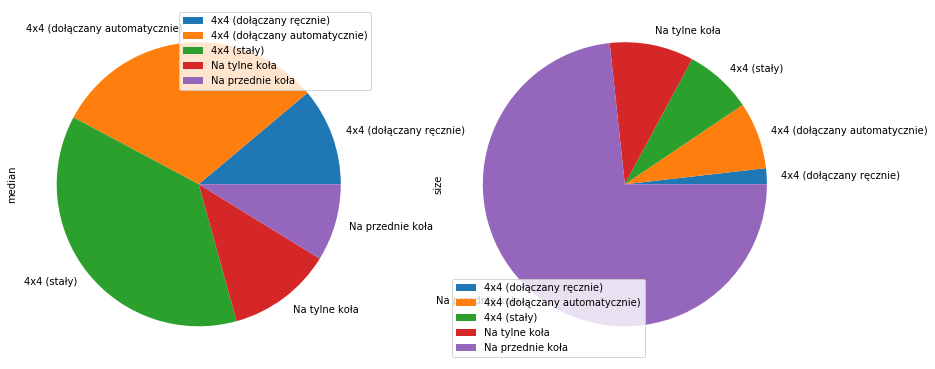

In [81]:
(
    df
      .groupby('param_napęd')['price_value']
      .agg([np.median, np.size])
      .sort_values(by='size', ascending=True)
      .head(50)
).plot(kind='pie', figsize=(14,10), subplots=True);